In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering

In [ ]:
from sklearn.metrics import (
    adjusted_rand_score,
    adjusted_mutual_info_score,
    normalized_mutual_info_score,
    mutual_info_score,
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.neighbors import NearestNeighbors
from math import comb
import warnings

In [ ]:
warnings.filterwarnings("ignore")
np.random.seed(42)

In [ ]:
def ensure_array(X):
    """Return numpy array of floats for feature matrices."""
    X = np.asarray(X, dtype=float)
    return X

In [ ]:
def encode_labels(y):
    """Return integer labels starting from 0."""
    le = LabelEncoder()
    return le.fit_transform(np.asarray(y))

In [ ]:
def rand_index(y_true, y_pred):
    """Unadjusted Rand Index (pair counting)."""
    n = len(y_true)
    tp_plus_tn = 0
    for i in range(n):
        for j in range(i + 1, n):
            same_true = (y_true[i] == y_true[j])
            same_pred = (y_pred[i] == y_pred[j])
            if (same_true and same_pred) or (not same_true and not same_pred):
                tp_plus_tn += 1
    total_pairs = comb(n, 2)
    return tp_plus_tn / total_pairs

In [ ]:
def safe_silhouette(X, labels):
    try:
        u = set(labels)
        if len(u) > 1 and len(u) < len(labels):
            return float(silhouette_score(X, labels))
        else:
            return np.nan
    except:
        return np.nan

In [ ]:
def compute_sse_ssb(X, labels):
    """Cohesion (SSE) and Separation (SSB). Ignore label -1 (noise)."""
    X = np.asarray(X, dtype=float)
    labels = np.asarray(labels)
    overall_mean = X.mean(axis=0)
    sse = 0.0
    ssb = 0.0
    for lab in np.unique(labels):
        if lab == -1:
            continue
        pts = X[labels == lab]
        if pts.shape[0] == 0:
            continue
        centroid = pts.mean(axis=0)
        sse += ((pts - centroid) ** 2).sum()
        ssb += pts.shape[0] * ((centroid - overall_mean) ** 2).sum()
    return float(sse), float(ssb)


In [ ]:
def relabel_consecutive(labels):
    """Map labels to 0..k-1, keep -1 for noise."""
    labels = np.asarray(labels)
    mapping = {}
    next_label = 0
    out = labels.copy()
    for i, l in enumerate(labels):
        if l == -1:
            out[i] = -1
            continue
        if l not in mapping:
            mapping[l] = next_label
            next_label += 1
        out[i] = mapping[l]
    return out

In [ ]:
def pam_kmedoids(X, k, max_iter=100, random_state=42):
    """
    Simple PAM implementation:
     - initialize medoids by random sampling
     - iteratively try swapping medoid with non-medoid to reduce total cost
    Returns labels (0..k-1)
    """
    rng = np.random.RandomState(random_state)
    X = np.asarray(X, dtype=float)
    n = X.shape[0]
    if k >= n:
        return np.arange(n)
    # initial medoids indices
    medoid_idx = rng.choice(n, size=k, replace=False)
    medoid_idx = medoid_idx.tolist()
    # compute pairwise distances once
    dists = np.linalg.norm(X[:, None, :] - X[None, :, :], axis=2)  # shape (n, n)
    def total_cost(meds):
        # cost = sum distance each point to its nearest medoid
        return dists[:, meds].min(axis=1).sum()
    current_cost = total_cost(medoid_idx)
    for it in range(max_iter):
        improved = False
        for m_i, med in enumerate(medoid_idx):
            for o in range(n):
                if o in medoid_idx:
                    continue
                # try swap medoid med with o
                trial = medoid_idx.copy()
                trial[m_i] = o
                trial_cost = dists[:, trial].min(axis=1).sum()
                if trial_cost < current_cost:
                    medoid_idx = trial
                    current_cost = trial_cost
                    improved = True
                    break  # accept first improving swap (classic PAM)
            if improved:
                break
        if not improved:
            break
    # final assignment
    labels = np.argmin(dists[:, medoid_idx], axis=1)
    return labels

In [ ]:
from sklearn.cluster import KMeans as SKKMeans
def bisecting_kmeans(X, k, random_state=42, max_tries=10):
    """
    Bisecting KMeans:
      - start with one cluster containing all points
      - repeatedly split the cluster with largest SSE using KMeans(k=2)
      - stop when number of clusters = k
    """
    X = np.asarray(X, dtype=float)
    clusters = {0: np.arange(len(X))}
    while len(clusters) < k:
        # compute SSE per cluster
        sse_per_cluster = {}
        for cid, idxs in clusters.items():
            pts = X[idxs]
            if pts.shape[0] == 0:
                sse_per_cluster[cid] = 0
            else:
                cen = pts.mean(axis=0)
                sse_per_cluster[cid] = ((pts - cen) ** 2).sum()
        # pick cluster with largest SSE to bisect
        to_split = max(sse_per_cluster, key=sse_per_cluster.get)
        idxs = clusters.pop(to_split)
        if len(idxs) <= 1:
            clusters[to_split] = idxs
            break
        # run KMeans(k=2) multiple times and pick best bisection
        best_labels = None
        best_inertia = np.inf
        for _ in range(max_tries):
            km = SKKMeans(n_clusters=2, n_init=10, random_state=random_state)
            sub_labels = km.fit_predict(X[idxs])
            inert = km.inertia_
            if inert < best_inertia:
                best_inertia = inert
                best_labels = sub_labels
        # assign two new cluster ids
        new_id = max(clusters.keys(), default=-1) + 1
        clusters[new_id] = idxs[best_labels == 0]
        clusters[new_id + 1] = idxs[best_labels == 1]
    # build final labels
    final_labels = np.empty(len(X), dtype=int)
    mapping = {}
    next_id = 0
    for cid, idxs in clusters.items():
        mapping[cid] = next_id
        final_labels[idxs] = next_id
        next_id += 1
    return final_labels


In [ ]:
def run_all_for_dataset(X, y_true, dataset_name, show_plots=True):
    X = ensure_array(X)
    y_true = encode_labels(y_true)
    n_clusters = len(np.unique(y_true))

    print(f"\n=== DATASET: {dataset_name} (n={X.shape[0]}, features={X.shape[1]}, classes={n_clusters}) ===\n")

    # standardize
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    # PCA for 2D plotting
    pca = PCA(n_components=2, random_state=42)
    X2 = pca.fit_transform(Xs)

    results = []

    # ---------- KMeans (k-means++) ----------
    km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=20, random_state=42)
    km_labels = relabel_consecutive(km.fit_predict(Xs))
    sse, ssb = compute_sse_ssb(Xs, km_labels)
    results.append(("KMeans (k-means++)", km_labels, sse, ssb))

    # ---------- K-Medoids (PAM) ----------
    pam_labels = relabel_consecutive(pam_kmedoids(Xs, n_clusters, random_state=42))
    sse, ssb = compute_sse_ssb(Xs, pam_labels)
    results.append(("KMedoids (PAM)", pam_labels, sse, ssb))

    # ---------- Bisecting KMeans ----------
    bis_labels = relabel_consecutive(bisecting_kmeans(Xs, n_clusters, random_state=42))
    sse, ssb = compute_sse_ssb(Xs, bis_labels)
    results.append(("Bisecting KMeans", bis_labels, sse, ssb))

    # ---------- Hierarchical (Agglomerative) ----------
    # plot dendrogram
    Z = linkage(Xs, method='ward')
    if show_plots:
        plt.figure(figsize=(10, 4))
        dendrogram(Z, truncate_mode='lastp', p=40, show_leaf_counts=True)
        plt.title(f"Dendrogram (Ward) - {dataset_name}")
        plt.tight_layout()
        plt.show()
    agg = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    agg_labels = relabel_consecutive(agg.fit_predict(Xs))
    sse, ssb = compute_sse_ssb(Xs, agg_labels)
    results.append(("Hierarchical (Agglomerative - ward)", agg_labels, sse, ssb))

    # ---------- DBSCAN ----------
    # heuristic to choose eps: 90th percentile of 5-NN distances
    neigh = NearestNeighbors(n_neighbors=5).fit(Xs)
    dists, _ = neigh.kneighbors(Xs)
    kdist = np.sort(dists[:, -1])
    eps_guess = float(np.percentile(kdist, 90))
    db = DBSCAN(eps=eps_guess, min_samples=5)
    db_labels = relabel_consecutive(db.fit_predict(Xs))
    sse, ssb = compute_sse_ssb(Xs, db_labels)
    results.append((f"DBSCAN (eps≈{eps_guess:.3f})", db_labels, sse, ssb))

    # ---------- OPTICS ----------
    opt = OPTICS(min_samples=5)
    opt_labels = relabel_consecutive(opt.fit_predict(Xs))
    sse, ssb = compute_sse_ssb(Xs, opt_labels)
    results.append(("OPTICS", opt_labels, sse, ssb))

    # ---------- Compute metrics for each algorithm and report ----------
    rows = []
    for algo_name, labels, sse_val, ssb_val in results:
        labels_arr = np.asarray(labels)
        # Replace class names with numeric values already done (y_true is numeric)
        # Compute metrics (use adjusted versions and mutual info variants)
        try:
            ri = rand_index(y_true, labels_arr)
        except Exception:
            ri = np.nan
        try:
            ari = float(adjusted_rand_score(y_true, labels_arr))
        except:
            ari = np.nan
        try:
            mi = float(mutual_info_score(y_true, labels_arr))
        except:
            mi = np.nan
        try:
            ami = float(adjusted_mutual_info_score(y_true, labels_arr))
        except:
            ami = np.nan
        try:
            nmi = float(normalized_mutual_info_score(y_true, labels_arr))
        except:
            nmi = np.nan
        sil = safe_silhouette(Xs, labels_arr)
        try:
            ch = float(calinski_harabasz_score(Xs, labels_arr)) if len(set(labels_arr)) > 1 else np.nan
        except:
            ch = np.nan
        try:
            dbi = float(davies_bouldin_score(Xs, labels_arr)) if len(set(labels_arr)) > 1 else np.nan
        except:
            dbi = np.nan

        rows.append({
            "Algorithm": algo_name,
            "n_clusters": len([l for l in np.unique(labels_arr) if l != -1]),
            "Rand": ri,
            "AdjRand": ari,
            "MutualInfo": mi,
            "AdjMutualInfo": ami,
            "NormMutualInfo": nmi,
            "Silhouette": sil,
            "CalinskiHarabasz": ch,
            "DaviesBouldin": dbi,
            "SSE": sse_val,
            "SSB": ssb_val
        })

    df = pd.DataFrame(rows)
    # nicer ordering of columns
    df = df[["Algorithm", "n_clusters", "Rand", "AdjRand", "MutualInfo", "AdjMutualInfo",
             "NormMutualInfo", "Silhouette", "CalinskiHarabasz", "DaviesBouldin", "SSE", "SSB"]]

    # Display summary table
    print(f"\nPerformance summary for {dataset_name}:\n")
    display(df.round(4))

    # Show PCA 2D visualizations for each algorithm
    if show_plots:
        nplots = len(results)
        cols = 3
        rowsplt = int(np.ceil(nplots / cols))
        fig, axes = plt.subplots(rowsplt, cols, figsize=(5 * cols, 4 * rowsplt))
        axes = axes.flatten()
        for ax, (algo_name, labels, _, _) in zip(axes, results):
            ax.scatter(X2[:, 0], X2[:, 1], c=labels, cmap='tab10', s=30)
            ax.set_title(algo_name)
            ax.set_xticks([]); ax.set_yticks([])
        # hide extra axes
        for ax in axes[len(results):]:
            ax.axis('off')
        plt.suptitle(f"PCA (2D) visualizations - {dataset_name}", fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    return df, results

In [ ]:
iris = datasets.load_iris()
wine = datasets.load_wine()


=== DATASET: Iris (n=150, features=4, classes=3) ===



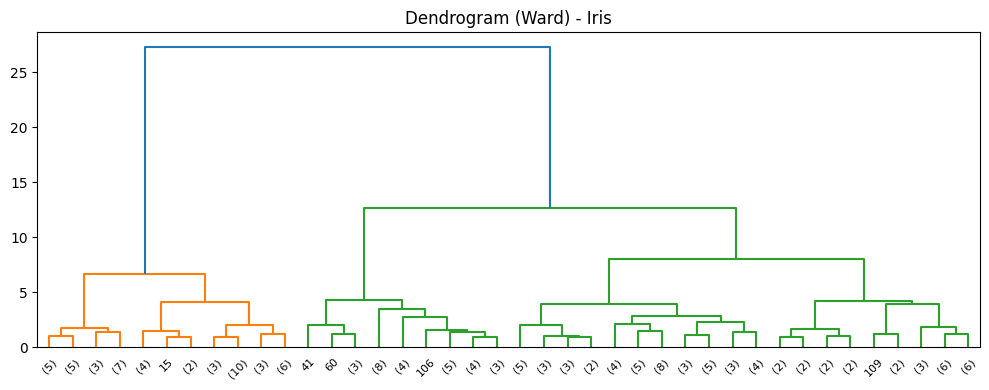


Performance summary for Iris:



,Algorithm,n_clusters,Rand,AdjRand,MutualInfo,AdjMutualInfo,NormMutualInfo,Silhouette,CalinskiHarabasz,DaviesBouldin,SSE,SSB
0,KMeans (k-means++),3,0.8322,0.6201,0.7241,0.6552,0.6595,0.4599,241.9044,0.8336,139.8205,460.1795
1,KMedoids (PAM),3,0.8415,0.6416,0.7405,0.6710,0.6750,0.4566,238.7630,0.8419,141.2271,458.7729
2,Bisecting KMeans,3,0.8322,0.6201,0.7241,0.6552,0.6595,0.4599,241.9044,0.8336,139.8205,460.1795
3,Hierarchical (Agglomerative - ward),3,0.8252,0.6153,0.7228,0.6713,0.6755,0.4467,222.7192,0.8035,148.8763,451.1237
4,DBSCAN (eps≈0.759),2,0.7730,0.5503,0.6389,0.6807,0.6858,0.5081,122.2918,3.2757,186.8301,366.5839
5,OPTICS,5,0.5121,0.0514,0.3082,0.2657,0.2924,-0.3009,8.3282,2.4253,3.7885,129.7627


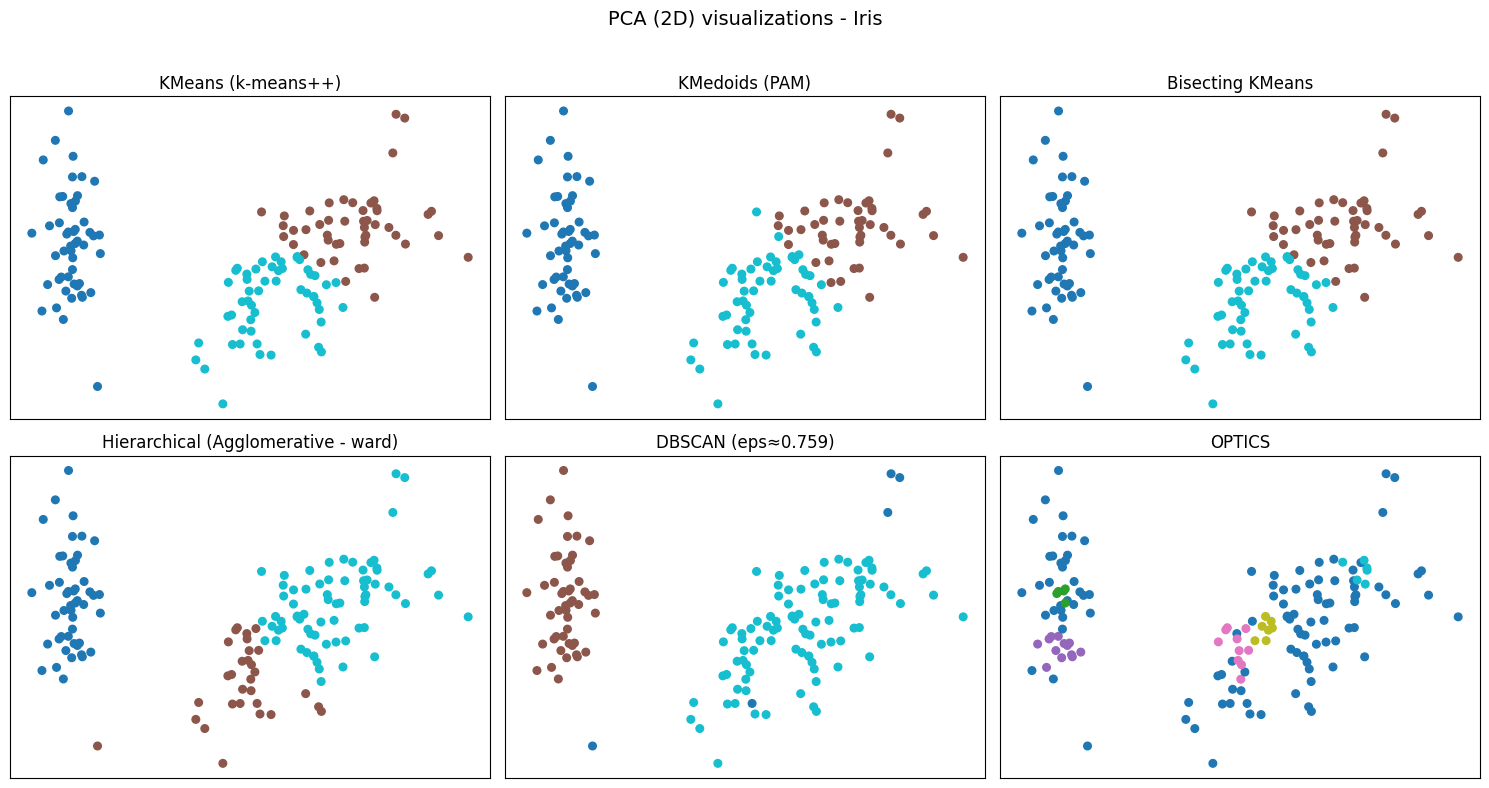

In [ ]:
df_iris, res_iris = run_all_for_dataset(iris.data, iris.target, "Iris", show_plots=True)


=== DATASET: Wine (n=178, features=13, classes=3) ===



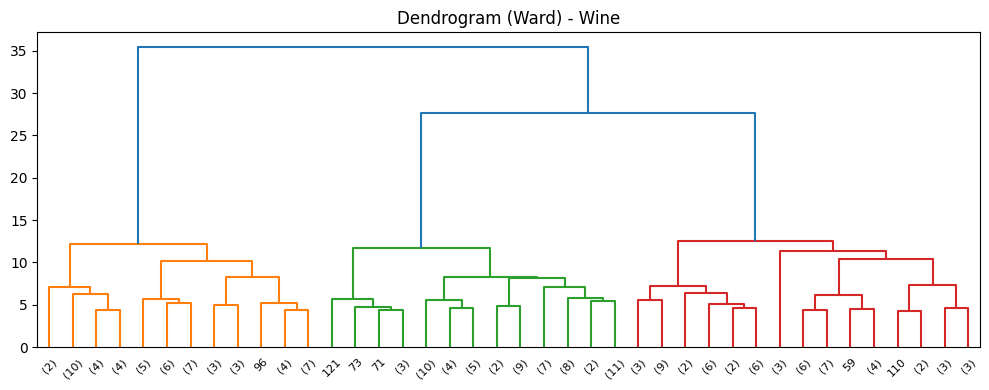


Performance summary for Wine:



,Algorithm,n_clusters,Rand,AdjRand,MutualInfo,AdjMutualInfo,NormMutualInfo,Silhouette,CalinskiHarabasz,DaviesBouldin,SSE,SSB
0,KMeans (k-means++),3,0.9543,0.8975,0.9545,0.8746,0.8759,0.2849,70.9400,1.3892,1277.9285,1036.0715
1,KMedoids (PAM),3,0.8840,0.7411,0.8490,0.7806,0.7829,0.2676,67.1223,1.4248,1309.4810,1004.5190
2,Bisecting KMeans,3,0.8130,0.5906,0.7515,0.7019,0.7051,0.2341,59.7425,1.5203,1375.1129,938.8871
3,Hierarchical (Agglomerative - ward),3,0.9065,0.7899,0.8584,0.7842,0.7865,0.2774,67.6475,1.4186,1305.0487,1008.9513
4,DBSCAN (eps≈3.127),1,0.3646,-0.0074,0.0324,0.0410,0.0504,0.2342,4.8536,2.9367,2054.3232,3.1400
5,OPTICS,4,0.4392,0.0358,0.1621,0.1680,0.1949,-0.1336,5.0571,1.6194,38.8681,225.8965


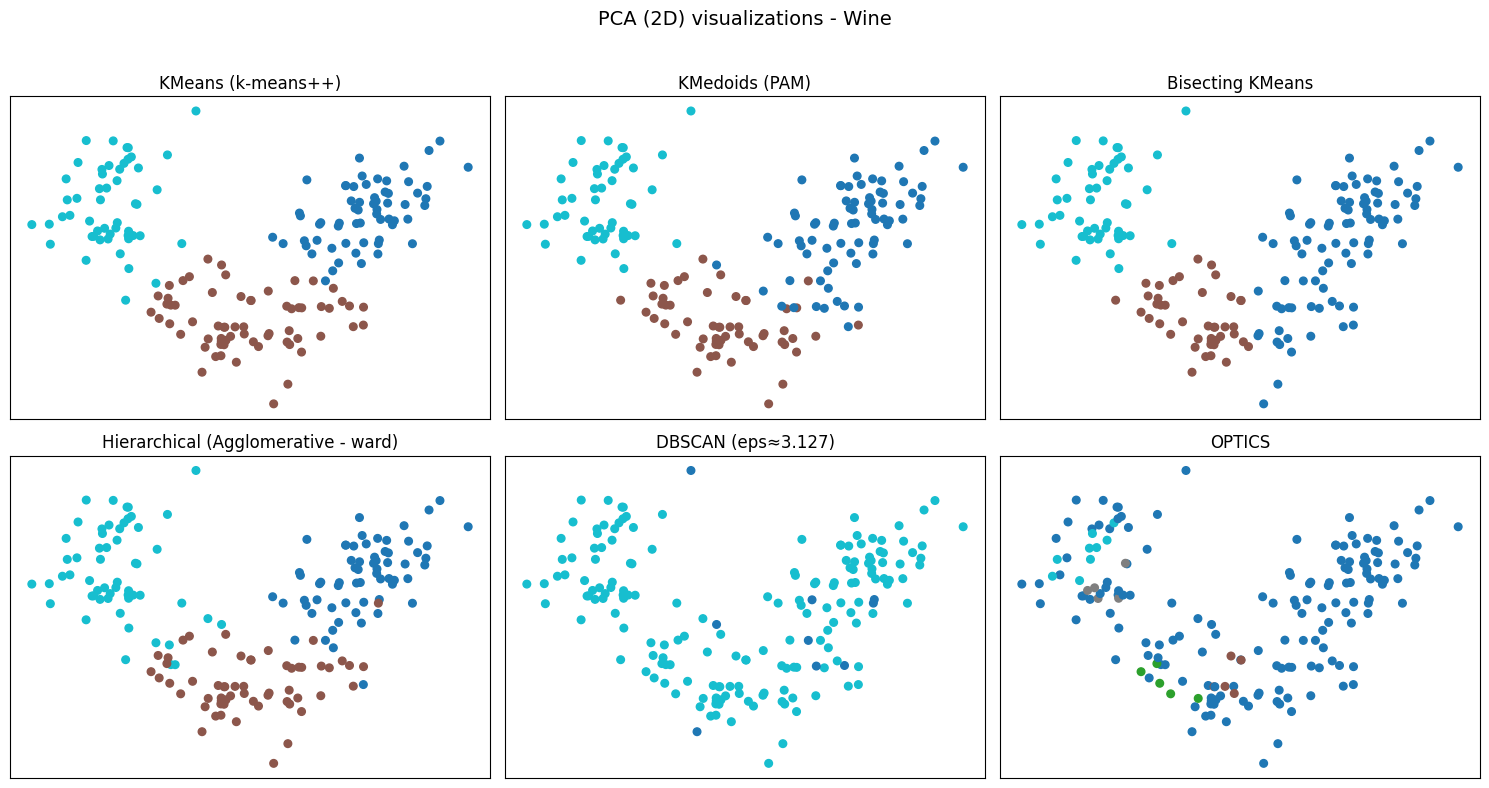

In [ ]:
df_wine, res_wine = run_all_for_dataset(wine.data, wine.target, "Wine", show_plots=True)